## Load libraries

In [7]:
import os
import math
from collections import Counter
import gdown
import glob

import numpy as np
import pandas as pd
import scipy
from PIL import Image as PILImage
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import tensorflow.keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from IPython.display import Image as DisplayImage

In [6]:
!git clone https://github.com/diego-taquiri/AutismSketchClassifier.git

Cloning into 'AutismSketchClassifier'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 72 (delta 3), reused 68 (delta 2), pack-reused 0
Receiving objects: 100% (72/72), 718.37 KiB | 2.81 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [29]:
file_id = '1WZ_dmnln5-Xltfq_lOASLMPIMKjLzGWD'
output_dir = './AutismSketchClassifier/models'
output_path = os.path.join(output_dir, 'resnet18_quickdraw_pretrained.keras')
os.makedirs(output_dir, exist_ok=True)
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1WZ_dmnln5-Xltfq_lOASLMPIMKjLzGWD
From (redirected): https://drive.google.com/uc?id=1WZ_dmnln5-Xltfq_lOASLMPIMKjLzGWD&confirm=t&uuid=8e2a5054-2733-402b-87f4-facd7defd199
To: /content/AutismSketchClassifier/models/resnet18_quickdraw_pretrained.keras
100%|██████████| 137M/137M [00:02<00:00, 52.8MB/s]


'./AutismSketchClassifier/models/resnet18_quickdraw_pretrained.keras'

## Cargar resnet18 sin top layer


In [30]:
model = load_model('./AutismSketchClassifier/models/resnet18_quickdraw_pretrained.keras')

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 28, 28, 64)           0         ['batch_normalization[0][0

Create a new model without the top layer


In [32]:
model = Model(inputs=model.input, outputs=model.get_layer('re_lu_16').output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 28, 28, 64)           0         ['batch_normalization[0]

### **Cargar dataset**

In [33]:
# Get image paths and labels
filenames = glob.glob('./AutismSketchClassifier/data/*/*.png')
labels = [os.path.basename(os.path.dirname(filename)) for filename in filenames]
filenames

['./AutismSketchClassifier/data/Con cuello/tmpxongwolu.png',
 './AutismSketchClassifier/data/Con cuello/tmppuhgsxp0.png',
 './AutismSketchClassifier/data/Con cuello/tmpsdontavx.png',
 './AutismSketchClassifier/data/Con cuello/tmpxpw2fsjn.png',
 './AutismSketchClassifier/data/Con cuello/tmpr61sk6oo.png',
 './AutismSketchClassifier/data/Con cuello/tmp8e84x0w6.png',
 './AutismSketchClassifier/data/Shaky lines/tmp0b8tjy6y.png',
 './AutismSketchClassifier/data/Shaky lines/tmp2gjqy7y5.png',
 './AutismSketchClassifier/data/Shaky lines/tmpjyopbwf7.png',
 './AutismSketchClassifier/data/Shaky lines/tmpjz8eqvme.png',
 './AutismSketchClassifier/data/Shaky lines/tmpi46ot2r6.png',
 './AutismSketchClassifier/data/Shaky lines/tmpqtr6uvtb.png',
 './AutismSketchClassifier/data/Sonrisa grande/tmp4uyg5cwu.png',
 './AutismSketchClassifier/data/Sonrisa grande/tmpzmc2wgzu.png',
 './AutismSketchClassifier/data/Sonrisa grande/tmpcaw_8fx1.png',
 './AutismSketchClassifier/data/Sonrisa grande/tmpzpzmklfw.png',
 '

Mostramos las imagenes del dataset

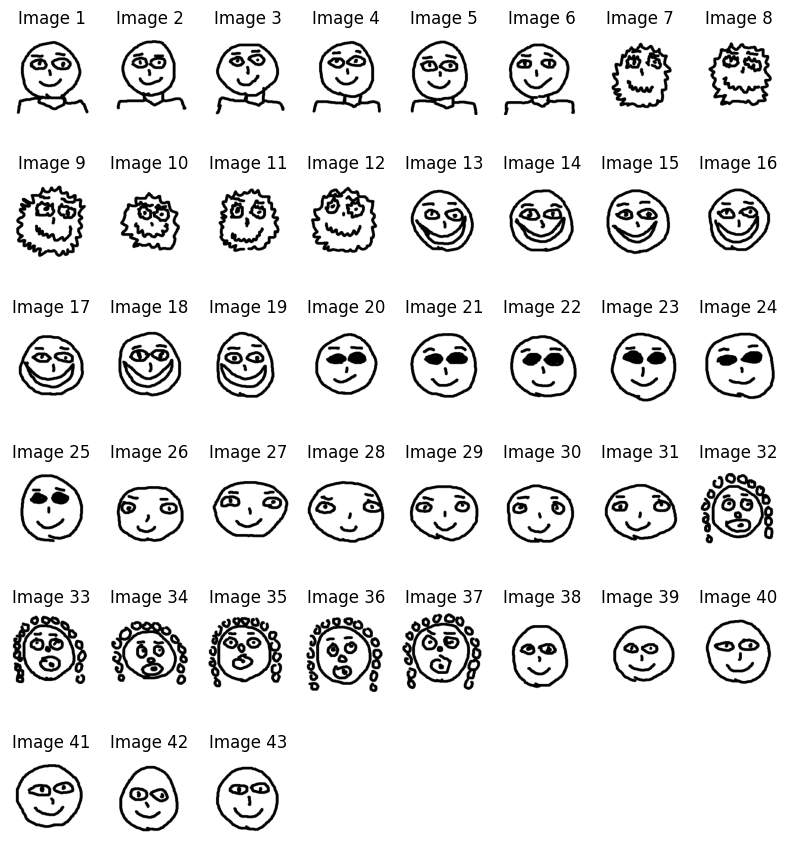

In [15]:
fig = plt.figure(figsize=(8, 9))
num_images = len(filenames)
images_per_row = 8
num_rows = (num_images // images_per_row) + int(num_images % images_per_row != 0)

for i in range(num_images):
    ax = fig.add_subplot(num_rows, images_per_row, i + 1)
    ax.imshow(imread(filenames[i]))
    ax.axis('off')
    ax.set_title(f"Image {i + 1}")

plt.tight_layout()
plt.show()

Preprocesamos y obtenemos un vector de representación para cada una de las imágenes del dataset

In [ ]:
def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = PILImage.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

In [19]:
def extract_features_and_preprocessed_images(filenames):
    target_size=(28, 28)
    features = []
    preprocessed_images = []
    for filename in filenames:
        img = PILImage.open(filename)
        img = remove_transparency(img)
        img_resized = img.resize(target_size)
        img_gray = img_resized.convert('L')
        preprocessed_images.append(img_gray)
        x = image.img_to_array(img_gray)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        features.append(model.predict(x).ravel())
    return np.array(features), preprocessed_images

In [20]:
# Split the data into training and test sets
filenames_train, filenames_test, labels_train, labels_test = train_test_split(filenames, labels, test_size=0.2, stratify=labels, random_state=42)

# Extract features and preprocessed images
features_train, preprocessed_images_train = extract_features_and_preprocessed_images(filenames_train)
features_test, preprocessed_images_test = extract_features_and_preprocessed_images(filenames_test)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

print(features_train.shape)
print(features_test.shape)



1/1 [==============================] - 0s 41ms/step
(34, 8192)
(9, 8192)


Visualizamos

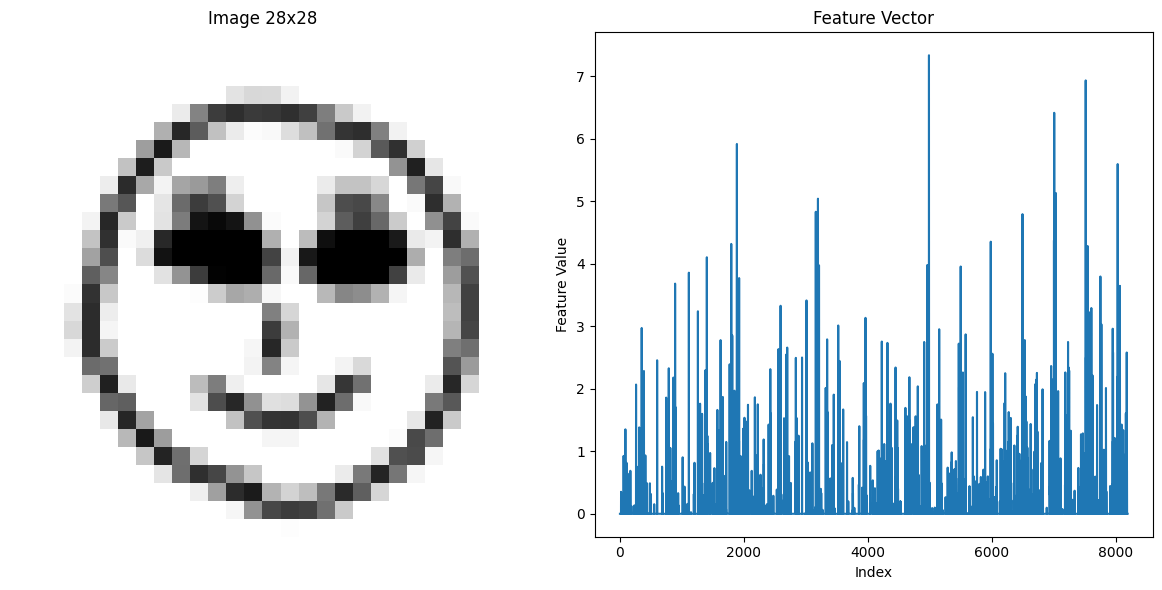

In [21]:
# Visualization
def visualize_image_and_features(img_gray, feature_vector):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the image on the first subplot
    axes[0].imshow(img_gray, cmap="gray")
    axes[0].set_title("Image 28x28")
    axes[0].axis("off")

    # Plot the feature vector on the second subplot
    axes[1].plot(feature_vector)
    axes[1].set_title("Feature Vector")
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("Feature Value")

    plt.tight_layout()
    plt.show()

# Visualize one of the images and its feature vector
index_to_visualize = 13  # Change this index to visualize different images
visualize_image_and_features(preprocessed_images_train[index_to_visualize], features_train[index_to_visualize])


# **Ploteo imagenes más similares (KNN)**


In [22]:
# tomar la distancia del coseno:
def distancia_cos(im1, im2):
  return 1 - np.dot(im1, im2) / (np.linalg.norm(im1) * np.linalg.norm(im2))

In [23]:
def k_vecinos_más_cercanos(vectores, index, k):
  vecinos = []
  im1 = vectores[index] # <--- vector de la imagen a la que estoy apuntando
  for i, im2 in enumerate(vectores):
    if index == i:
      continue
    D = distancia_cos(im1, im2)
    vecinos.append([i, D]) # <--- guardando el índice de la imagen, distancia

  vecinos.sort(key = lambda x : x[1])
  # vecinos.sort()
  # x[0] <--- índices
  return [x[0] for x in vecinos]

Imagen de Query
Imágenes Recuperadas (Total Imágenes: 3 imágenes)


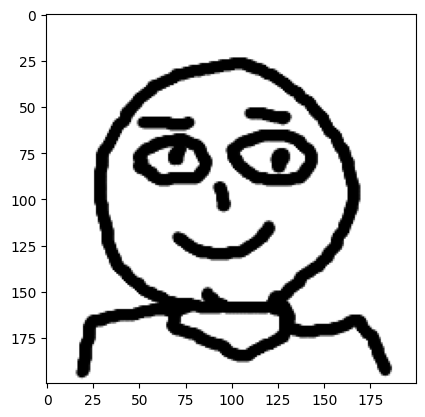

In [24]:
#@title Mostrar los K logos más similares { run: "auto" }
idx = 0 #@param {type:"slider", min:0, max:2340, step:1}
k = 3 #@param {type:"slider", min:1, max:30, step:1}
print("Imagen de Query")
img = PILImage.open(filenames[idx])
plt.imshow(img)

idxs = k_vecinos_más_cercanos(features, idx, k)


########################################
####   Desarrolle su código aquí   #####
########################################
print("Imágenes Recuperadas (Total Imágenes: {} imágenes)".format(k))

#########################################

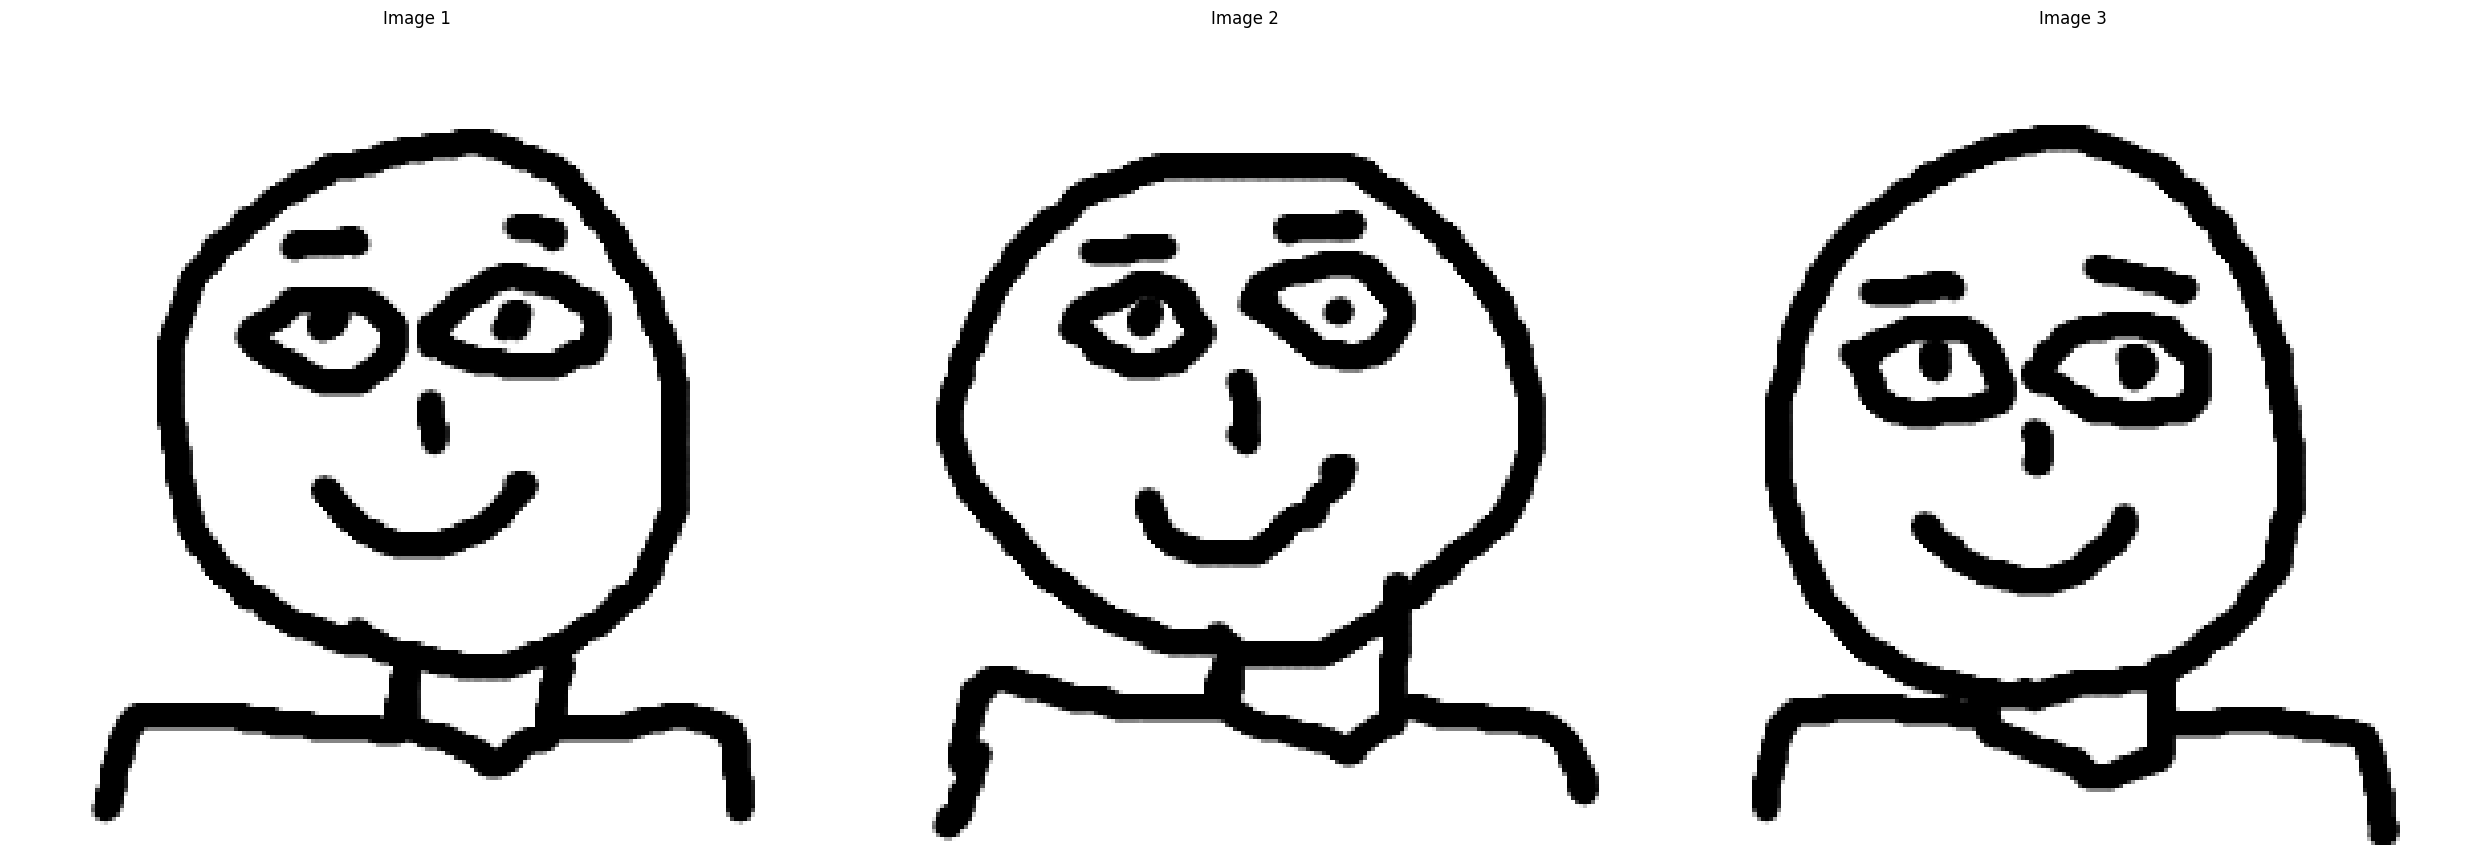

In [25]:
fig = plt.figure(figsize=(25, 9))

for i in range(k):
    ax = fig.add_subplot(1, k, i + 1)  # Adjust the subplot layout
    ax.imshow(imread(filenames[idxs[i]]))
    ax.axis('off')  # Turn off axis numbering and labels
    ax.set_title(f"Image {i + 1}")  # Optionally set a title for each subplot

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Predict label

In [26]:
#clasifica 1 imagen del test
def classify_image(feature, all_features, labels, k=3):
    # Add the new feature to the list of all features for finding neighbors
    all_features = np.vstack([all_features, feature])
    index = len(all_features) - 1

    # Find k nearest neighbors
    neighbors_indices = k_vecinos_más_cercanos(all_features, index, k)

    # Get the labels of the first k nearest neighbors
    neighbors_labels = [labels[i] for i in neighbors_indices[:k]]

    # Remove the last feature added (cleanup)
    all_features = all_features[:-1]

    # Determine the majority label
    label_counter = Counter(neighbors_labels)
    majority_label = label_counter.most_common(1)[0][0]

    return majority_label

In [27]:
# clasifica todas las imgagenes del test
predicted_labels = []
for feature_test in features_test:
    predicted_label = classify_image(feature_test, features, labels)
    predicted_labels.append(predicted_label)

predicted_labels

['Ojos distanciados',
 'Con cuello',
 'Sin pupilas',
 'Shaky lines',
 'Sin cejas',
 'Sonrisa grande',
 'Shaky lines',
 'Sonrisa grande',
 'Dibujos Presquemáticos']

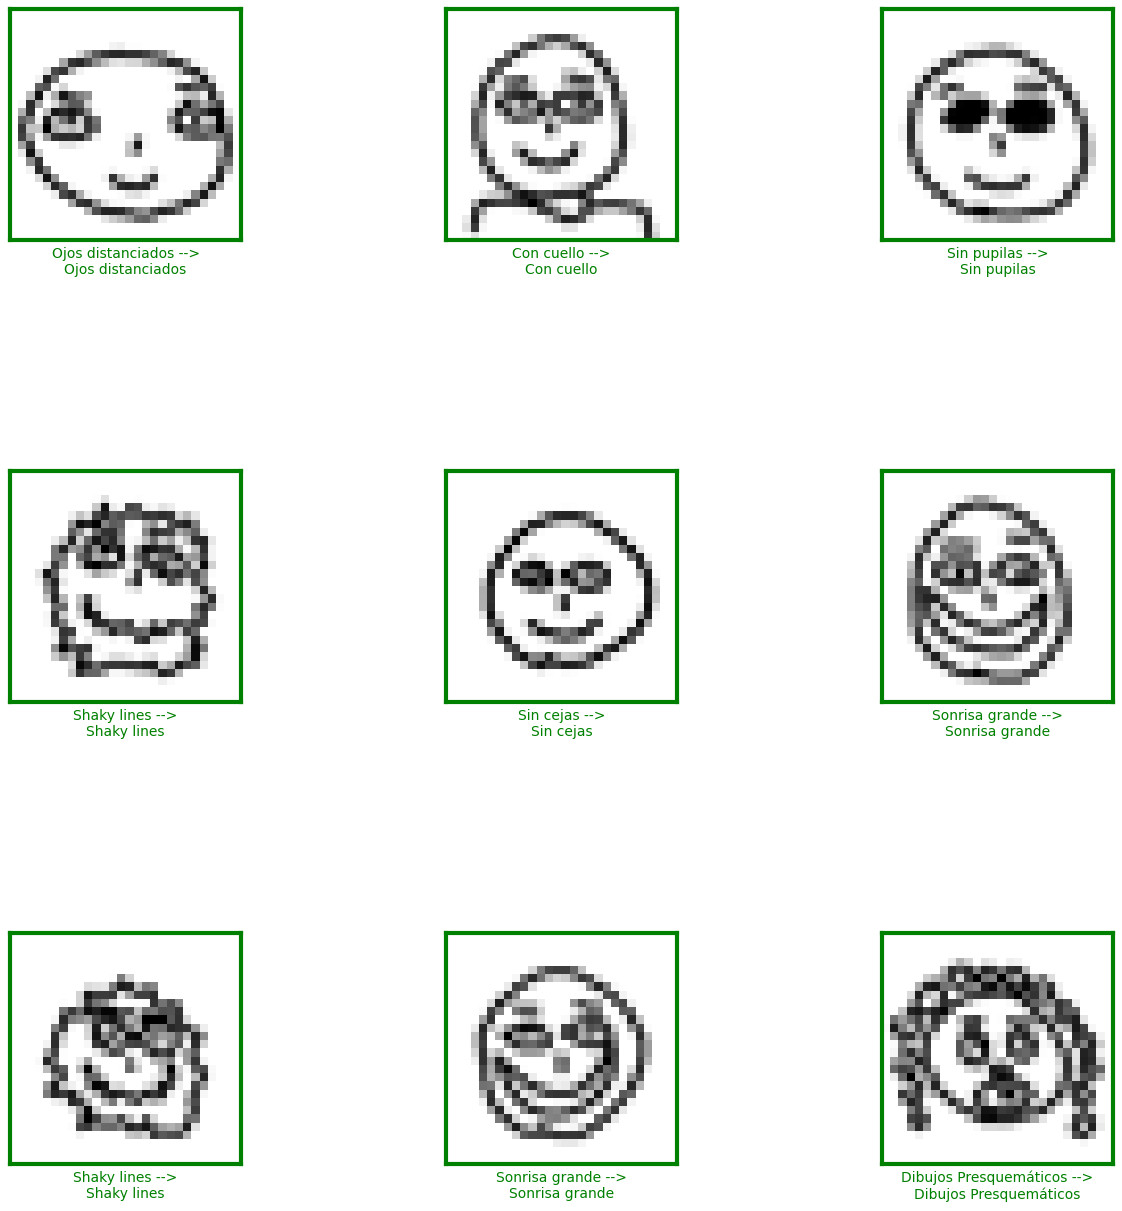

In [28]:
# Visualization of the predictions
def visualize_predictions(filenames, labels_true, labels_pred):
    numbers_to_display = min(64, len(filenames))
    num_cells = math.ceil(math.sqrt(numbers_to_display))
    plt.figure(figsize=(15, 15))

    for i in range(numbers_to_display):
        img = PILImage.open(filenames[i])
        img = remove_transparency(img)
        img_resized = img.resize((28, 28))
        img_gray = img_resized.convert('L')
        x = np.array(img_gray)

        y_true = labels_true[i]
        y_pred = labels_pred[i]

        color = 'green' if y_true == y_pred else 'red'

        plt.subplot(num_cells, num_cells, i + 1)
        plt.imshow(x, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(f"{y_true} -->\n{y_pred}", color=color)

        # Add border color
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.subplots_adjust(hspace=1, wspace=0.5)
    plt.show()


# Visualize the results
visualize_predictions(filenames_test, labels_test, predicted_labels)